# 第 8 章 图像识别进阶

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
# 下载数据集 & 安装依赖
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
!tar -xvf flower_photos.tgz 
!mkdir data && mv flower_photos data/flower_photos
!pip install pillow

## 8.1 数据集处理

### 8.1.1 准备数据集

In [1]:
import os, shutil
import pathlib
import random
import IPython.display as display
from sklearn.model_selection import train_test_split

data_root = pathlib.Path('data/flower_photos/')
for item in data_root.iterdir():
    print(item)

data/flower_photos/daisy
data/flower_photos/roses
data/flower_photos/dandelion
data/flower_photos/tulips
data/flower_photos/sunflowers
data/flower_photos/LICENSE.txt


In [2]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

# 打乱数据顺序
random.shuffle(all_image_paths)

print(len(all_image_paths))  # 3670
all_image_paths[:5]

# all_image_paths 是包含所有图像文件路径的数组
# ['data/flower_photos/roses/5061135742_2870a7b691_n.jpg',
#  'data/flower_photos/dandelion/5613466853_e476bb080e.jpg',
#  'data/flower_photos/tulips/14053292975_fdc1093571_n.jpg',
#  'data/flower_photos/dandelion/2634666217_d5ef87c9f7_m.jpg',
#  'data/flower_photos/dandelion/5598591979_ed9af1b3e9_n.jpg']

# 从图像路径解析出类别名
all_image_labels = [pathlib.Path(path).parent.name for path in all_image_paths]

3670


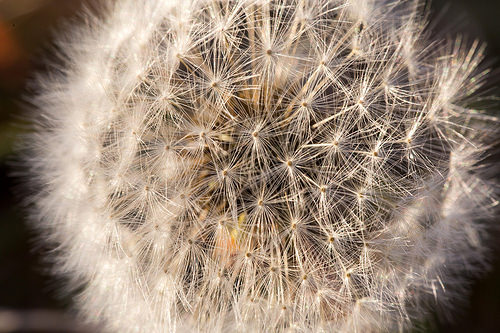

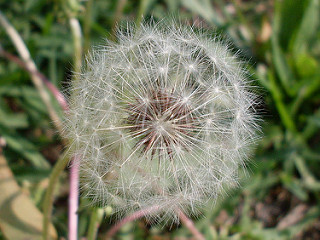

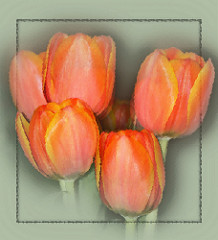

In [3]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))

In [4]:
# 使用 train_test_split 方法拆分数据集
train_x, valid_x, train_y, valid_y = train_test_split(all_image_paths,
                                                      all_image_labels,
                                                      train_size = 0.8,
                                                      random_state = 104)

def crate_sub_dataset(images, labels, dataset_path):
    for index, image_path in enumerate(images):
        image_label = labels[index]

        # 创建标签数据集目录
        target_dir = os.path.join(dataset_path, image_label)
        pathlib.Path(target_dir).mkdir(parents=True, exist_ok=True)

        # 复制图像文件到目标文件夹
        target_path = os.path.join(target_dir, pathlib.Path(image_path).name)
        shutil.copyfile(image_path, target_path)
    return dataset_path

# 删除已存在文件
shutil.rmtree('data/flower-set/train', ignore_errors=True)
shutil.rmtree('data/flower-set/valid', ignore_errors=True)

train_dataset_path = crate_sub_dataset(train_x, train_y, 'data/flower-set/train')
valid_dataset_path = crate_sub_dataset(valid_x, valid_y, 'data/flower-set/valid')

### 8.1.2 数据集预处理

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 创建两个生成器，rescale 属性表示将图像张量乘以 1/255 归一化
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# 使用生成器，读取目录中图像
train_generator = train_datagen.flow_from_directory(
    directory=train_dataset_path, # 数据读取目录
    target_size=(192, 192),    # 张量尺寸，所有图像将缩减至整个尺寸
    batch_size=100)            # 批次大小

valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dataset_path,
    target_size=(192, 192),
    batch_size=100)

Found 2936 images belonging to 5 classes.
Found 734 images belonging to 5 classes.


In [6]:
for data_batch, label_batch in train_generator:
    print(f"data_batch shape: {data_batch.shape}")
    print(f"label_batch shape: {label_batch.shape}")
    break
# data_batch shape: (100, 192, 192, 3)
# label_batch shape: (100, 5)

data_batch shape: (100, 192, 192, 3)
label_batch shape: (100, 5)


    
### 8.1.3 简单卷积神经网络

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python import keras

plt.rcParams['figure.dpi'] = 120

L = keras.layers

# 构建和编译模型
base_model = keras.Sequential([
    L.Conv2D(input_shape=(192, 192, 3), filters=32, kernel_size=5, strides=1),
    L.MaxPool2D(pool_size=2, strides=2),
    L.Conv2D(filters=64, kernel_size=3, strides=1),
    L.MaxPool2D(pool_size=2, strides=2),
    L.Flatten(),
    L.Dense(128, activation=tf.nn.relu),
    L.Dense(5, activation=tf.nn.softmax)
])
base_model.compile(
    optimizer=tf.optimizers.Adam(lr=5e-4),
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])
base_model.summary()

tf_board_path = 'tf_dir/chapter08/base_model'
shutil.rmtree(tf_board_path, ignore_errors=True)

# 使用 fit_generator 方法训练模型
history = base_model.fit_generator(
      train_generator,                 # 训练批次生成器
      steps_per_epoch=30,              # 训练批次数量
      epochs=50,                       # 总共训练轮数
      validation_data=valid_generator, # 验证批次生成器
      validation_steps=8,              # 验证批次数量
      verbose=0,
      callbacks=[keras.callbacks.TensorBoard(tf_board_path)],
)

del base_model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 188, 188, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 135424)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               17334400  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6

In [8]:
plt.rcParams['figure.dpi'] = 120

def visualize_keras_history(history):
    plt.figure()
    # 设定子图大小
    plt.subplots(figsize=(10,9))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('train and validate accuracy') # 添加图形标题

    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('train and validate loss') # 添加图形标题

    plt.show()

<Figure size 720x480 with 0 Axes>

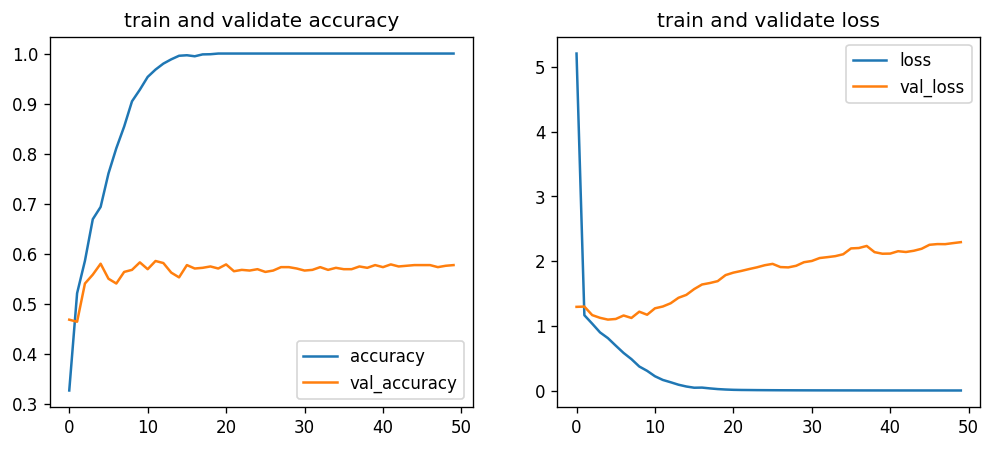

In [9]:
visualize_keras_history(history)

### 8.1.4 数据增强

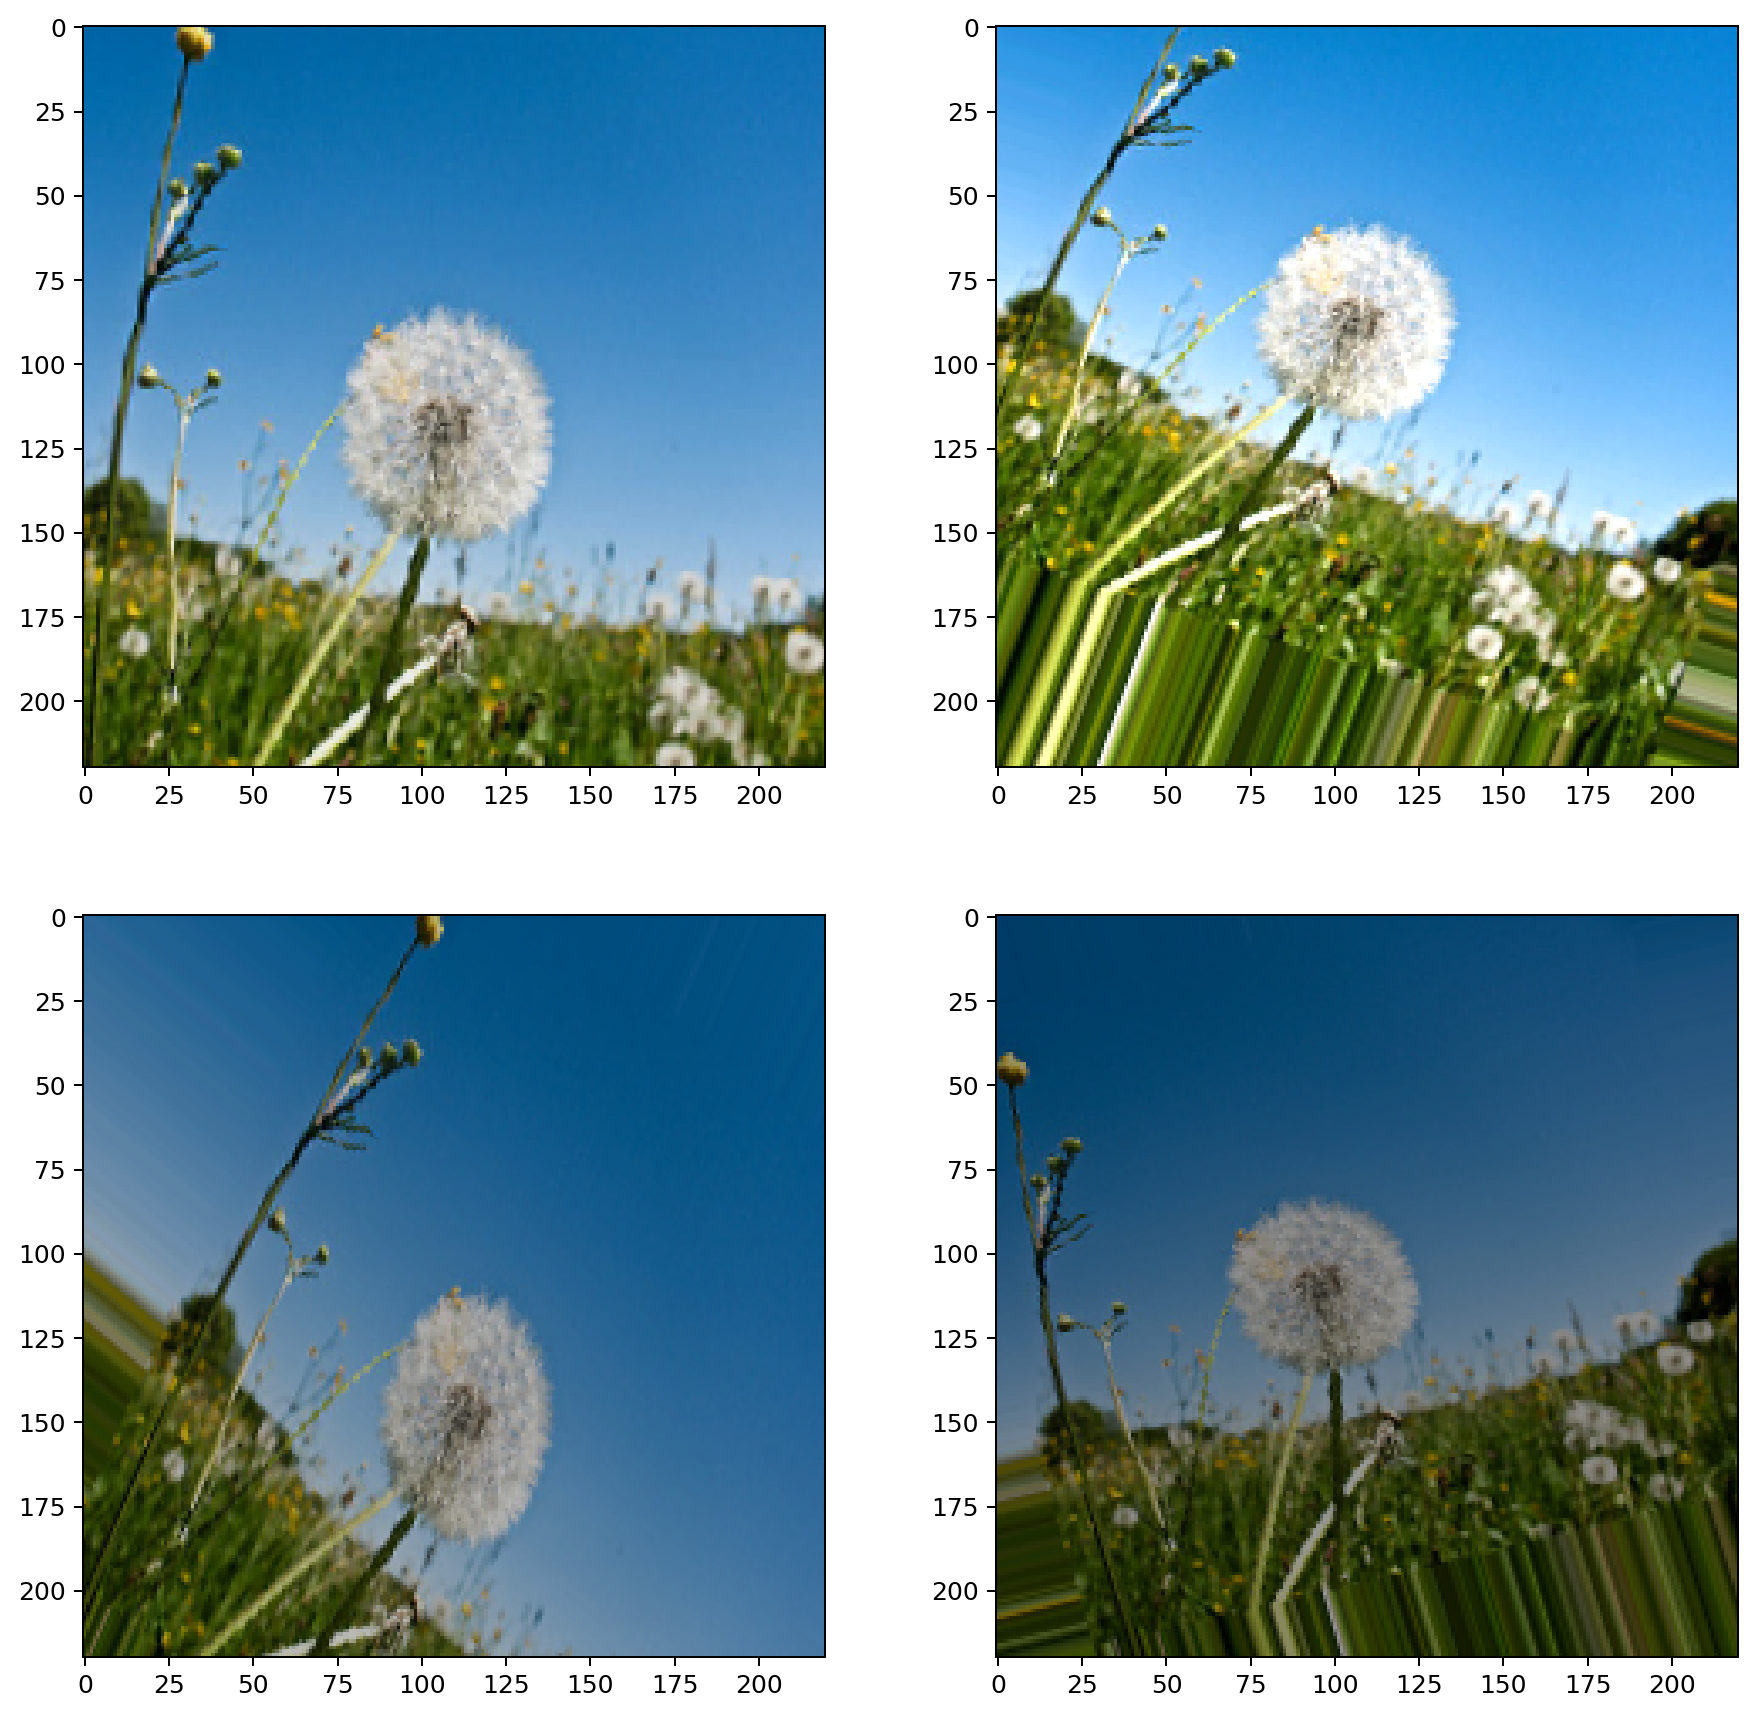

In [10]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 180

L = keras.layers

# 读取某一张图像张量
img_path = './data/flower_photos/dandelion/5909154147_9da14d1730_n.jpg'
img = load_img(img_path, target_size=(220, 220)) # 读取图像
x = img_to_array(img)                            # 将图像转换为 Numpy 数组
x = x.reshape((1,) + x.shape)                    # 将图像形状改为 (1, 220, 220, 3)

# 初始化图像数据生成器
random_data_gen = ImageDataGenerator(
    rescale=1./255,              # 归一化
    rotation_range=40,           # 图像旋转范围
    width_shift_range=0.2,       # 图像水平平移的范围（相对宽度的比例）
    height_shift_range=0.2,      # 图像垂直平移的范围（相对宽度的比例）
    shear_range=0.2,             # 图像错切变换的角度范围
    zoom_range=0.2,              # 图像缩放的范围
    brightness_range=(0.6, 1.2), # 图像亮度调整范围
    horizontal_flip=True         # 是否随机水平翻转
)

# 生成随机变换后的批次。由于循环式无限的，需要手动 break 来中断。
i = 0
plt.figure(figsize=(12,12))
# random_data_gen.flow 方法使用给定文件路径数组初始化一个生成器
for batch in random_data_gen.flow(x, batch_size=1):
    plt.subplot(2, 2, i+1)
    plt.imshow(batch[0])
    plt.grid(False)

    i = i + 1
    if i == 4:
        break
plt.show()

In [11]:
random_data_gen = ImageDataGenerator(
    rescale=1./255,              # 归一化
    rotation_range=40,           # 图像旋转范围
    width_shift_range=0.2,       # 图像水平平移的范围（相对宽度的比例）
    height_shift_range=0.2,      # 图像垂直平移的范围（相对宽度的比例）
    shear_range=0.2,             # 图像错切变换的角度范围
    zoom_range=0.2,              # 图像缩放的范围
    brightness_range=(0.6, 1.2), # 图像亮度调整范围
    horizontal_flip=True         # 是否随机水平翻转
)

# 不能增强验证数据
valid_data_gen = ImageDataGenerator(rescale=1./255)

train_aug_gen = random_data_gen.flow_from_directory( # this function takes images from folders and feeds to Imagedatagenerator
        train_dataset_path,
        target_size=(192, 192),
        batch_size=100,
        class_mode='categorical'
)

valid_aug_gen = valid_data_gen.flow_from_directory(
        valid_dataset_path,
        target_size=(192, 192),
        batch_size=100,
        class_mode='categorical',
        shuffle=False)

Found 2936 images belonging to 5 classes.
Found 734 images belonging to 5 classes.


In [12]:
# 再次使用同样的模型以便对比效果
aug_model = keras.Sequential([
    L.Conv2D(input_shape=(192, 192, 3), filters=32, kernel_size=5, strides=1),
    L.MaxPool2D(pool_size=2, strides=2),
    L.Conv2D(filters=64, kernel_size=3, strides=1),
    L.MaxPool2D(pool_size=2, strides=2),
    L.Flatten(),
    L.Dense(128, activation=tf.nn.relu),
    L.Dense(5, activation=tf.nn.softmax)
])
aug_model.compile(optimizer=tf.optimizers.Adam(lr=5e-4),
                   loss=tf.losses.CategoricalCrossentropy(),
                   metrics=['accuracy'])
aug_model.summary()

tf_board_path = 'tf_dir/chapter08/aug_model'
shutil.rmtree(tf_board_path, ignore_errors=True)


# 由于这个模型不会出现过拟合，所以我们训练 100 轮来获得的更好的结果
aug_history = aug_model.fit_generator(
      train_aug_gen,                   # 训练批次生成器
      steps_per_epoch=30,              # 训练批次数量
      epochs=100,                      # 总共训练轮数
      validation_data=valid_aug_gen,   # 验证批次生成器
      validation_steps=8,              # 验证批次数量
      callbacks=[keras.callbacks.TensorBoard(tf_board_path)]
)
del aug_model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 188, 188, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 92, 92, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 135424)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               17334400  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

<Figure size 1080x720 with 0 Axes>

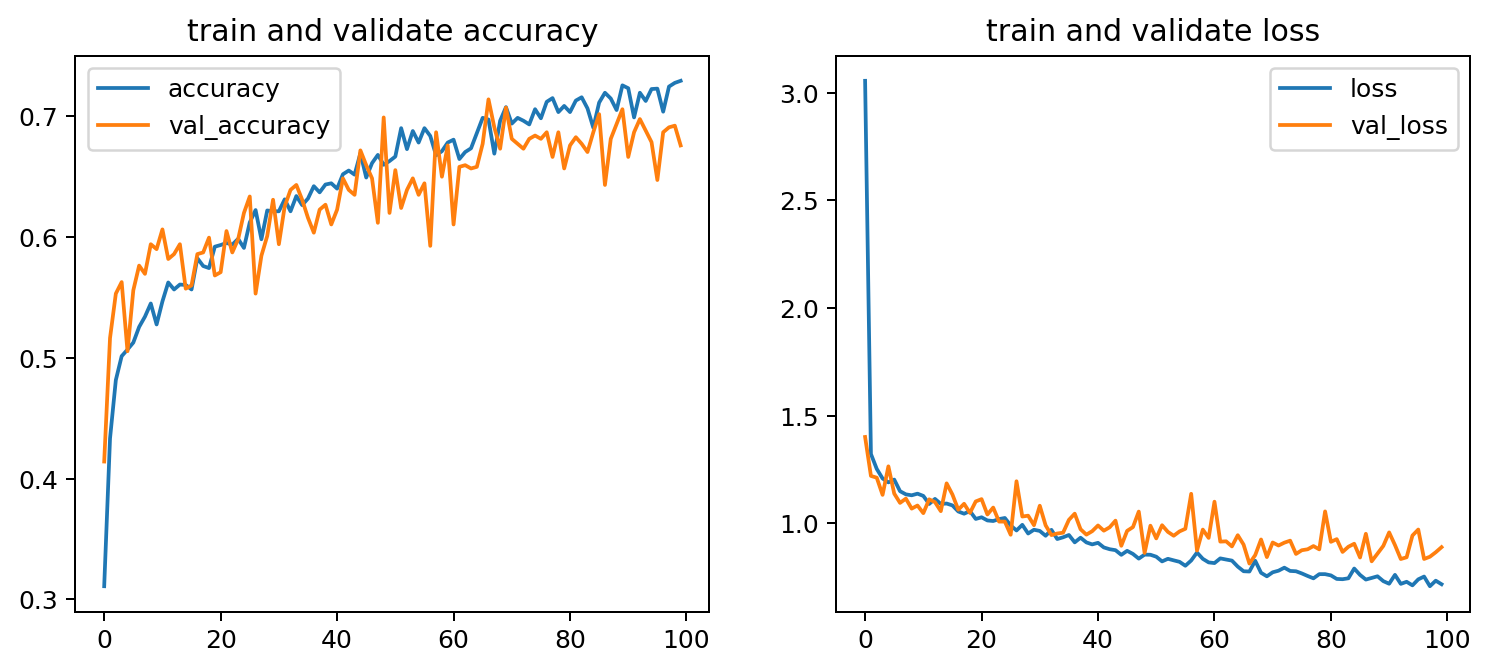

In [13]:
visualize_keras_history(aug_history)

## 8.2 迁移学习

### 8.2.1 VGG16 预训练模型

In [14]:
from tensorflow.keras.applications import VGG16

vgg = VGG16(weights='imagenet')
vgg.summary()

553467904/553467096 [==============================] - 462s 1us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

### 8.2.2 特征提取

In [15]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights='imagenet',      # 加载 imagenet 权重，如果传 None 则随机初始化权重
                 include_top=False,       # 是否包括模型最后的全连接分类器，这里不需要
                 input_shape=(192,192,3)) # 输入图像尺寸
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0     

In [16]:
# 冻结卷积基中所有层
# 注意修改模型层 trainable 属性后需要重新编译模型，否则不会生效
for layer in vgg_base.layers:
    layer.trainable = False

L = keras.layers
# 创建新模型
feature_extract_model = keras.Sequential([
    vgg_base,    # 使用卷积基模型作为第一层，相当于把这个模型所有的层加到新模型中
    L.Flatten(), # 使用一个 Flatten 把上层特征拉平成一维张量
    L.Dense(128, activation=tf.nn.relu),
    L.Dropout(0.5),
    L.Dense(5, activation=tf.nn.softmax)
])

feature_extract_model.compile(
    optimizer=tf.optimizers.Adam(lr=2e-4),
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

feature_extract_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               2359424   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 17,074,757
Trainable params: 2,360,069
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
tf_board_path = 'tf_dir/chapter08/vgg_feature_extract'
shutil.rmtree(tf_board_path, ignore_errors=True)

# 开始训练
vgg_feature_extract_hist = feature_extract_model.fit_generator(
      train_aug_gen,                   # 训练批次生成器
      steps_per_epoch=30,              # 训练批次数量
      epochs=50,                       # 总共训练轮数
      validation_data=valid_aug_gen,   # 验证批次生成器
      validation_steps=8,              # 验证批次数量
      verbose=0,
      callbacks=[keras.callbacks.TensorBoard(tf_board_path)]
)    
del feature_extract_model

<Figure size 1080x720 with 0 Axes>

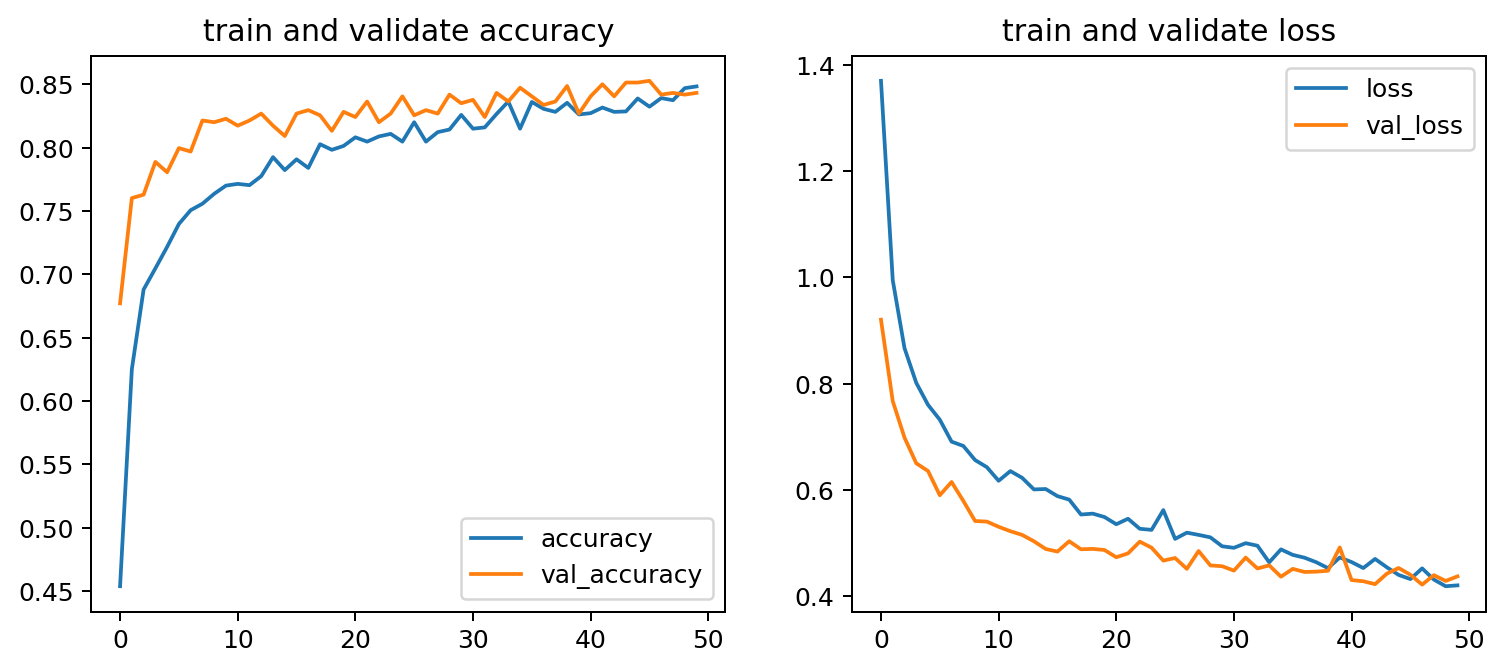

In [18]:
visualize_keras_history(vgg_feature_extract_hist)

### 8.2.3 微调模型

In [26]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.applications import VGG16

# 加载预训练 VGG16 模型卷积基
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

# 冻结卷积基最后四层以外的层
for layer in vgg_base.layers[:-4]:
    layer.trainable = False

# 创建新模型
vgg_model = keras.Sequential([
    vgg_base,
    L.Flatten(),
    L.Dense(64, activation=tf.nn.relu),
    L.Dropout(0.5),
    L.Dense(5, activation=tf.nn.softmax)
])

# 注意这里一定要用很小的学习率，否则会优化过程中会破坏最后一层的权重，达不到微调效果
vgg_model.compile(
    optimizer=tf.optimizers.Adam(lr=1e-4),
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

vgg_model.summary()

tf_board_path = 'tf_dir/chapter08/vgg_fine_tune'
shutil.rmtree(tf_board_path, ignore_errors=True)

# 开始训练
vgg_fine_tune_hist = vgg_model.fit_generator(
      train_aug_gen,                   # 训练批次生成器
      steps_per_epoch=30,              # 训练批次数量
      epochs=50,                       # 总共训练轮数
      validation_data=valid_aug_gen,   # 验证批次生成器
      validation_steps=8,              # 验证批次数量
      callbacks=[keras.callbacks.TensorBoard(tf_board_path)]
)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                1179712   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 325       
Total params: 15,894,725
Trainable params: 8,259,461
Non-trainable params: 7,635,264
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 49s 2s/step - loss: 1.3162 - accuracy: 0.4588 - v

<Figure size 1080x720 with 0 Axes>

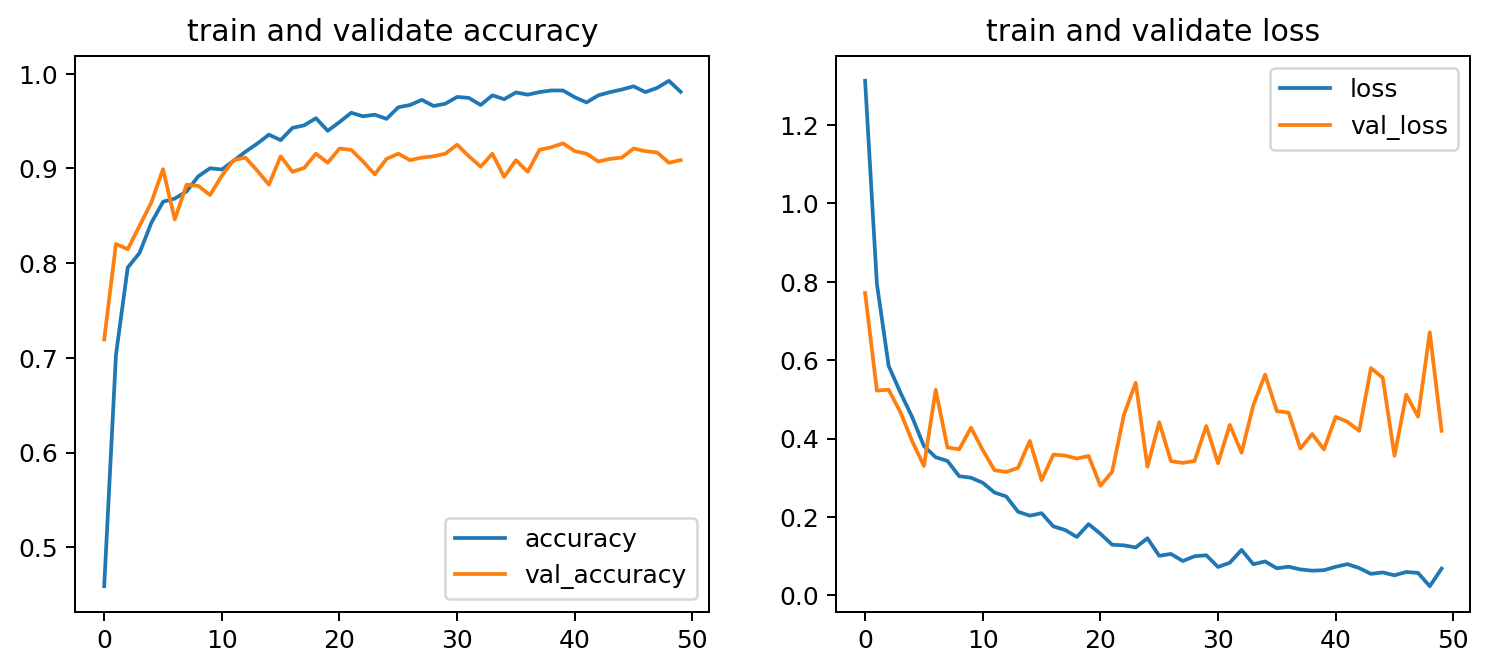

In [27]:
visualize_keras_history(vgg_fine_tune_hist)

### 8.2.4 保存模型

In [28]:
import json

# 创建目录
model_folder = pathlib.Path('outputs/flower_recognizer/vgg16')
model_folder.mkdir(parents=True, exist_ok=True)

# 保存模型
vgg_model.save(os.path.join(model_folder, 'model.h5'))
# 保存分类索引
with open(os.path.join(model_folder, 'label2idx.json'), 'w') as f:
    f.write(json.dumps(train_aug_gen.class_indices))
del vgg_model

## 8.3 TensorHub 迁移学习

In [29]:
import os
import tensorflow as tf
import tensorflow_hub as hub

os.environ['TFHUB_CACHE_DIR'] = './data/tf_cache'
MODEL_PATH = "https://hub.tensorflow.google.cn/google/imagenet/mobilenet_v2_050_192/classification/4"

In [30]:
hub_model = tf.keras.Sequential([
    # 初始化 MobileNet 层
    hub.KerasLayer(MODEL_PATH,
                   input_shape=(192, 192, 3),
                   trainable=True),
    # 在 MobieNet 后面拼接分类层
    L.Dense(64, activation=tf.nn.relu),
    L.Dropout(0.5),
    L.Dense(5, activation=tf.nn.softmax)
])

hub_model.compile(
    optimizer=tf.optimizers.Adam(lr=1e-4),
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

In [31]:
tf_board_path = 'tf_dir/chapter08/hub_model'
shutil.rmtree(tf_board_path, ignore_errors=True)

# 开始训练
hub_model_his = hub_model.fit_generator(
      train_aug_gen,                   # 训练批次生成器
      steps_per_epoch=30,              # 训练批次数量
      epochs=30,                       # 总共训练轮数
      validation_data=valid_aug_gen,   # 验证批次生成器
      validation_steps=8,              # 验证批次数量
      callbacks=[keras.callbacks.TensorBoard(tf_board_path)]
)

Epoch 1/30
30/30 [==============================] - 43s 1s/step - loss: 1.6331 - accuracy: 0.4639 - val_loss: 0.7682 - val_accuracy: 0.7439
Epoch 2/30
30/30 [==============================] - 36s 1s/step - loss: 0.9551 - accuracy: 0.6717 - val_loss: 0.5924 - val_accuracy: 0.8188
Epoch 3/30
30/30 [==============================] - 37s 1s/step - loss: 0.7679 - accuracy: 0.7606 - val_loss: 0.5189 - val_accuracy: 0.8474
Epoch 4/30
30/30 [==============================] - 36s 1s/step - loss: 0.6589 - accuracy: 0.7953 - val_loss: 0.4816 - val_accuracy: 0.8515
Epoch 5/30
30/30 [==============================] - 37s 1s/step - loss: 0.5775 - accuracy: 0.8239 - val_loss: 0.4848 - val_accuracy: 0.8569
Epoch 6/30
30/30 [==============================] - 37s 1s/step - loss: 0.5466 - accuracy: 0.8369 - val_loss: 0.4585 - val_accuracy: 0.8719
Epoch 7/30
30/30 [==============================] - 37s 1s/step - loss: 0.5069 - accuracy: 0.8556 - val_loss: 0.4548 - val_accuracy: 0.8774
Epoch 8/30
30/30 [==

<Figure size 1080x720 with 0 Axes>

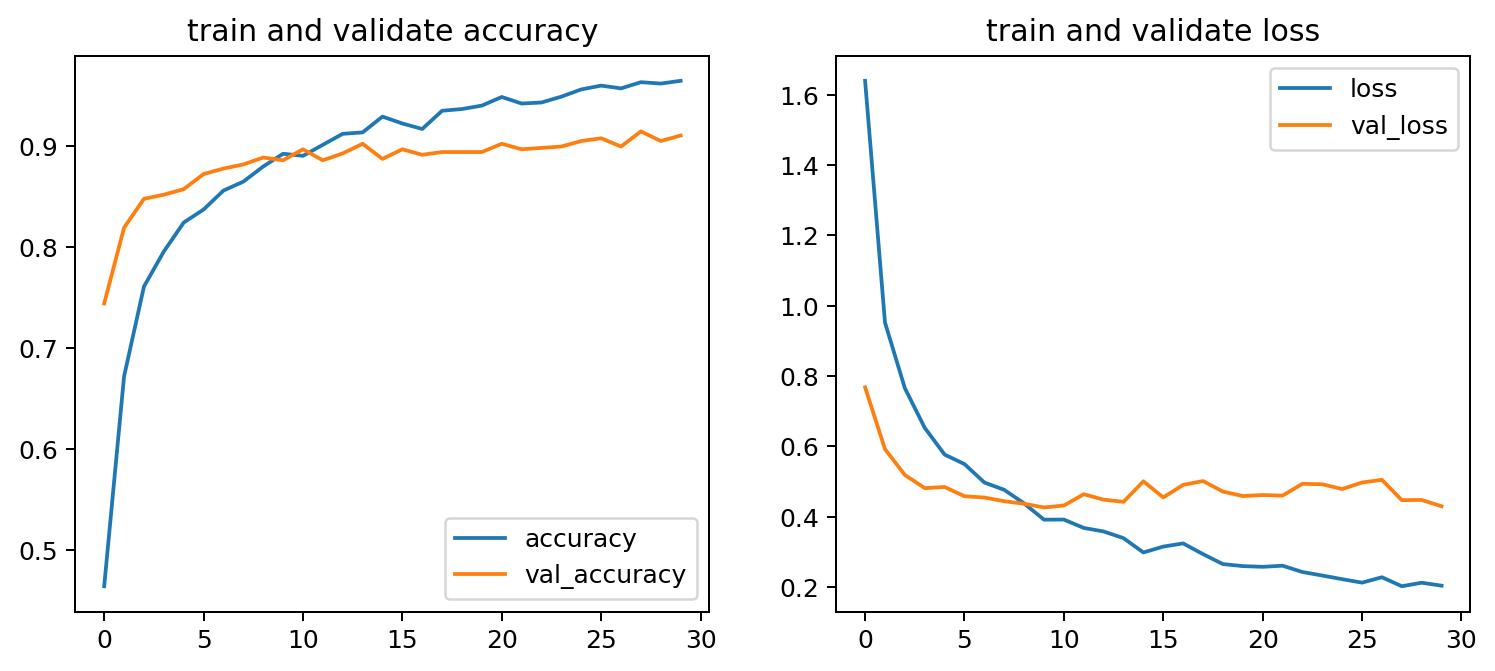

In [32]:
visualize_keras_history(hub_model_his)

In [33]:
import json

# 创建目录
model_folder = pathlib.Path('outputs/flower_recognizer/mobile_net')
model_folder.mkdir(parents=True, exist_ok=True)

# 保存模型
hub_model.save(os.path.join(model_folder, 'model.h5'))
# 保存分类索引
with open(os.path.join(model_folder, 'label2idx.json'), 'w') as f:
    f.write(json.dumps(train_aug_gen.class_indices))

del hub_model